In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
'''
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
'''

'\ngpus = tf.config.experimental.list_physical_devices("GPU")\nfor gpu in gpus:\n    tf.config.experimental.set_memory_growth(gpu, True)\n'

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.1987129780000032
GPU (s):
0.036668261000016855
GPU speedup over CPU: 32x


In [5]:
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/rdata512"
# Train Paths
pre_image_path_train = DATA_PATH + "/train_pre/images" #input_1
masks_path_train = DATA_PATH + "/train_post/targets"   # input_2
post_image_path_train = DATA_PATH + "/train_post/images" # target

train_pre_images_names = !ls -1 "{pre_image_path_train}"
train_masks_names = !ls -1 "{masks_path_train}"
train_post_images_names = !ls -1 "{post_image_path_train}"

train_pre_images_names = sorted(train_pre_images_names)
train_masks_names = sorted(train_masks_names)
train_post_images_names = sorted( train_post_images_names)



In [6]:

print( f" len of train_pre_images_names = {len(train_pre_images_names)}" )
print( train_pre_images_names[:3] )

print( f"\n\nlen of train_masks_names = {len(train_masks_names)}" )
print( train_masks_names[:3] )

print( f"\n\nlen of train_post_images_names = {len(train_post_images_names)}" )
print( train_post_images_names[:3] )

 len of train_pre_images_names = 2799
['guatemala-volcano_00000000_pre_disaster.png', 'guatemala-volcano_00000001_pre_disaster.png', 'guatemala-volcano_00000002_pre_disaster.png']


len of train_masks_names = 2799
['guatemala-volcano_00000000_post_disaster_target.png', 'guatemala-volcano_00000001_post_disaster_target.png', 'guatemala-volcano_00000002_post_disaster_target.png']


len of train_post_images_names = 2799
['guatemala-volcano_00000000_post_disaster.png', 'guatemala-volcano_00000001_post_disaster.png', 'guatemala-volcano_00000002_post_disaster.png']


In [7]:
# Test Paths
pre_image_path_test = DATA_PATH + "/test_pre/images" #input_1
masks_path_test = DATA_PATH + "/test_post/targets"   # input_2
post_image_path_test = DATA_PATH + "/test_post/images" # target

test_pre_images_names = !ls -1 "{pre_image_path_test}"
test_masks_names = !ls -1 "{masks_path_test}"
test_post_images_names = !ls -1 "{post_image_path_test}"

test_pre_images_names = sorted(test_pre_images_names)
test_masks_names = sorted(test_masks_names)
test_post_images_names = sorted( test_post_images_names)

#-------------------------------------------------------------------------------
test_pre_images_names = test_pre_images_names[8:]
test_pre_images_names= sorted( test_pre_images_names) 
test_pre_images_names.pop()

print( f" len of test_pre_images_names = {len(test_pre_images_names)}" )
print( test_pre_images_names[:3] )


test_masks_names = test_masks_names[8:]
test_masks_names = sorted( test_masks_names)

print( f"\n\nlen of test_masks_names = {len(test_masks_names)}" )
print( test_masks_names[:3] )

test_post_images_names = sorted( test_post_images_names)
print( f"\n\nlen of test_post_images_names = {len(test_post_images_names)}" )
print( test_post_images_names[:3] )

 len of test_pre_images_names = 925
['hurricane-florence_00000013_pre_disaster.png', 'hurricane-florence_00000019_pre_disaster.png', 'hurricane-florence_00000029_pre_disaster.png']


len of test_masks_names = 925
['hurricane-florence_00000013_post_disaster_target.png', 'hurricane-florence_00000019_post_disaster_target.png', 'hurricane-florence_00000029_post_disaster_target.png']


len of test_post_images_names = 925
['hurricane-florence_00000013_post_disaster.png', 'hurricane-florence_00000019_post_disaster.png', 'hurricane-florence_00000029_post_disaster.png']


In [8]:
IMAGE_SIZE = 256

# Resize image function
def resize( input_image,target_image, image_size = IMAGE_SIZE):
  input_image = tf.image.resize(input_image, [image_size, image_size], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR )
  target_image = tf.image.resize( target_image, [image_size, image_size], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR )

  return input_image, target_image


# Normalize images [0,254] to [-1,+1]
def normalize(input_image, target_image):
  input_image  =  (input_image/127.5) - 1
  target_image  =  (target_image/127.5) - 1

  return input_image, target_image 


# Augmentation of data: Random Crop + flip
def random_jitter( input_image, target_image ):

  input_image, target_image = resize( input_image, target_image, 286 )

  stacked_image = tf.stack( [input_image, target_image], axis = 0 )
  cropped_image = tf.image.random_crop( stacked_image, size = [2, IMAGE_SIZE, IMAGE_SIZE, 4] )

  input_image, target_image = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:
    input_image  = tf.image.flip_left_right(input_image) 
    target_image = tf.image.flip_left_right(target_image)

  return input_image, target_image


In [9]:
def load_image(filename, augment = True, from_training = True):
  '''
   input1 := Pre-image
   input2 := Mask post-image

   target := Post image
  '''
  if len( tf.strings.split(filename, sep = "pre") ) == 2 :
    filename_input1 = tf.strings.split( filename, sep = "pre" )[0] + 'pre' + tf.strings.split( filename, sep = "pre" )[-1]
    filename_target = tf.strings.split( filename, sep = "pre" )[0] + 'post' + tf.strings.split( filename, sep = "pre" )[-1]
    filename_input2 = tf.strings.split( filename_target, sep = ".png")[0] + "_target.png" 

  elif len( tf.strings.split( filename, sep = "post") ) == 2: 
    filename_input1  =  tf.strings.split( filename, sep = "post" )[0] + 'pre' + tf.strings.split( filename, sep = "post" )[-1]
    filename_target  =  tf.strings.split( filename, sep = "post" )[0] + 'post' + tf.strings.split( filename, sep = "post" )[-1]
    filename_input2  =  tf.strings.split( filename_target, sep = ".png")[0] + "_target.png"
  else:
    filename_input1 = ""
    filename_input2 = ""
    filename_target = ""


  if from_training:
    pre_image  = tf.cast( tf.image.decode_png( tf.io.read_file( pre_image_path_train + '/'  + filename_input1 ), channels = 3 ), tf.float32)
    mask_image  = tf.cast( tf.image.decode_png( tf.io.read_file( masks_path_train + '/'  + filename_input2 ), channels = 1 ), tf.float32)
    
    target_image = tf.cast( tf.image.decode_png( tf.io.read_file(  post_image_path_train + '/' + filename_target ), channels = 3 ), tf.float32)
  else:
    pre_image  = tf.cast( tf.image.decode_png( tf.io.read_file( pre_image_path_test + '/'  + filename_input1 ), channels = 3 ), tf.float32)
    mask_image  = tf.cast( tf.image.decode_png( tf.io.read_file( masks_path_test + '/'  + filename_input2 ), channels = 1 ), tf.float32)

    target_image = tf.cast( tf.image.decode_png( tf.io.read_file(  post_image_path_test + '/' + filename_target ), channels = 3 ), tf.float32)

  concat = tf.experimental.numpy.dstack( (mask_image, pre_image) )
  
  target_image = tf.experimental.numpy.dstack( (mask_image, target_image) )
    
  concat, target_image = resize( concat, target_image, IMAGE_SIZE)

  
  if augment:
      concat, target_image = random_jitter( concat, target_image)
  
  concat, target_image = normalize( concat, target_image)
  
  
  
  

  return concat, target_image


In [10]:
example_input, example_target = load_image(train_pre_images_names[9])
example_target.shape

TensorShape([256, 256, 4])

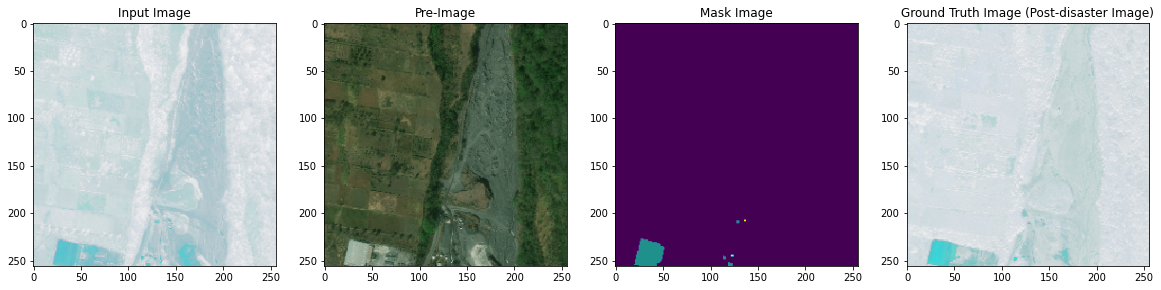

In [11]:
mask_example, pre_image_example = tf.experimental.numpy.split(
                                                                example_input, [1],  axis=-1
                                                              )
mask_example = tf.squeeze(mask_example)

fig, axes = plt.subplots(1,4, figsize = (20,8))
axes[0].imshow( example_input*0.5 + 0.5 )
axes[1].imshow( pre_image_example*0.5 + 0.5)
axes[2].imshow( mask_example*0.5 + 0.5 )
axes[3].imshow( example_target*0.5 + 0.5)
axes[0].title.set_text( 'Input Image' )
axes[1].title.set_text( 'Pre-Image' )
axes[2].title.set_text( 'Mask Image' )
axes[3].title.set_text( 'Ground Truth Image (Post-disaster Image)' )
plt.show()

In [12]:
def load_train_image(filename):
  return load_image(filename = filename, augment = True, from_training = True)


def load_test_image(filename):
  return load_image( filename = filename, augment = False, from_training = False)



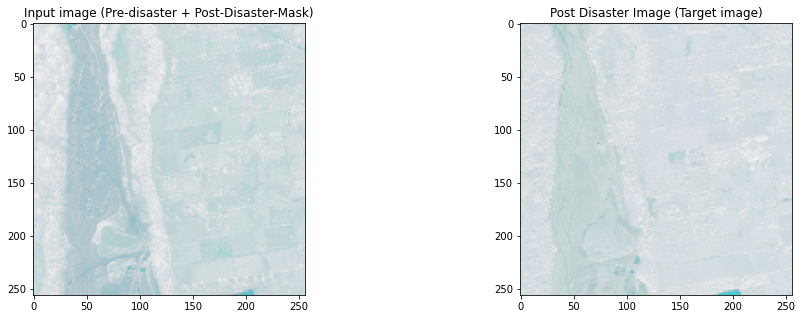

In [13]:
input_example, target_example = load_train_image( train_pre_images_names[9] )

fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow( input_example*0.5 + 0.5 )
axes[1].imshow( target_example*0.5 + 0.5 )
axes[0].title.set_text( 'Input image (Pre-disaster + Post-Disaster-Mask)' )
axes[1].title.set_text( 'Post Disaster Image (Target image)' )
plt.show()

In [14]:
BATCH_SIZE = 1
np.random.shuffle(train_pre_images_names)
train_dataset = tf.data.Dataset.from_tensor_slices(train_pre_images_names)
train_dataset = train_dataset.map( load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: ((None, 256, 256, 4), (None, 256, 256, 4)), types: (tf.float32, tf.float32)>

In [15]:
test_dataset = tf.data.Dataset.from_tensor_slices( test_pre_images_names)
test_dataset = test_dataset.map( load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<BatchDataset shapes: ((None, 256, 256, 4), (None, 256, 256, 4)), types: (tf.float32, tf.float32)>

In [16]:
# downsample block
def downsample(filters, size, apply_batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters = filters, kernel_size = size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if apply_batchnorm == True:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result


down_model = downsample(filters = 3, size = 4)
down_result = down_model(tf.expand_dims(example_input, axis = 0))
print(down_result.shape)

(1, 128, 128, 3)


In [17]:
# upsample block
def upsample(filters, size, apply_dropout = False):
    init = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if apply_dropout == True:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result



up_model = upsample(filters = 3, size = 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [18]:
OUTPUT_CHANNELS = 4
def generator():
    
    inputs = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 4])

    down_stack = [
        downsample(filters = 64,  size = 4, apply_batchnorm = False),
        downsample(filters = 128, size = 4),
        downsample(filters = 256, size = 4),
        downsample(filters = 512, size = 4),
        downsample(filters = 512, size = 4),
        downsample(filters = 512, size = 4),
        downsample(filters = 512, size = 4),
        downsample(filters = 512, size = 4)
    ]
    
    
    up_stack = [
        upsample(filters = 512, size = 4, apply_dropout = True),
        upsample(filters = 512, size = 4, apply_dropout = True),
        upsample(filters = 512, size = 4, apply_dropout = True),
        upsample(filters = 512, size = 4),
        upsample(filters = 256, size = 4),
        upsample(filters = 128, size = 4),
        upsample(filters =  64, size = 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    

    last = Conv2DTranspose(filters = OUTPUT_CHANNELS, kernel_size = 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
   
    x = last(x)
    return Model(inputs = inputs, outputs = x)

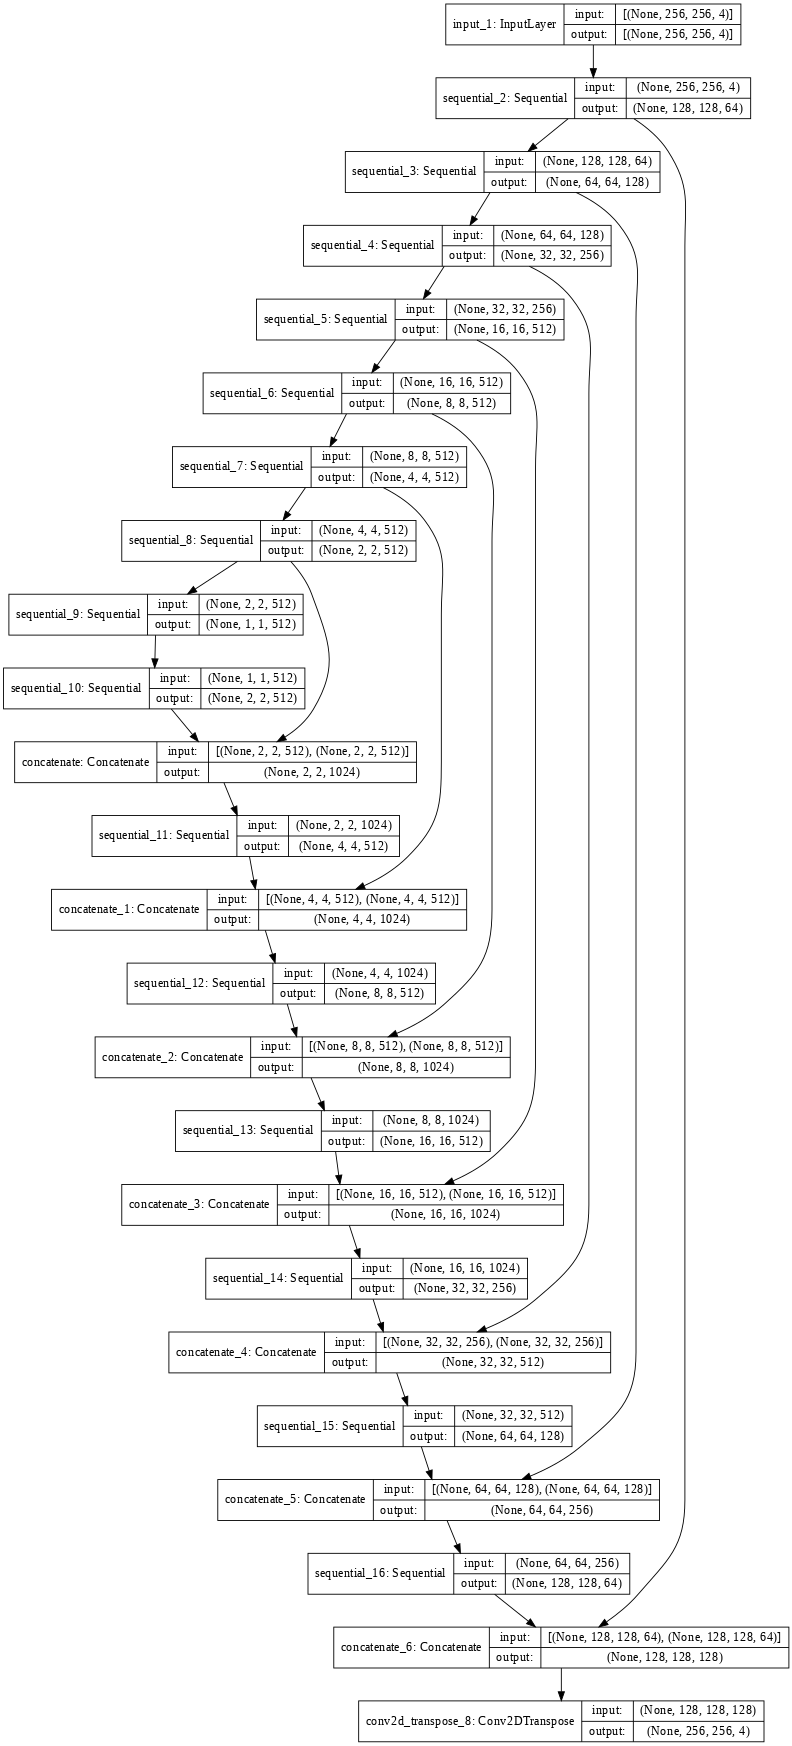

In [19]:
gen = generator()
plot_model( gen, show_shapes=True, dpi = 64)

In [20]:
LAMBDA = 100

In [21]:
from tensorflow.keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [23]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 4], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 4], name = "target_image")

    x = Concatenate()([inp, tar])


    
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

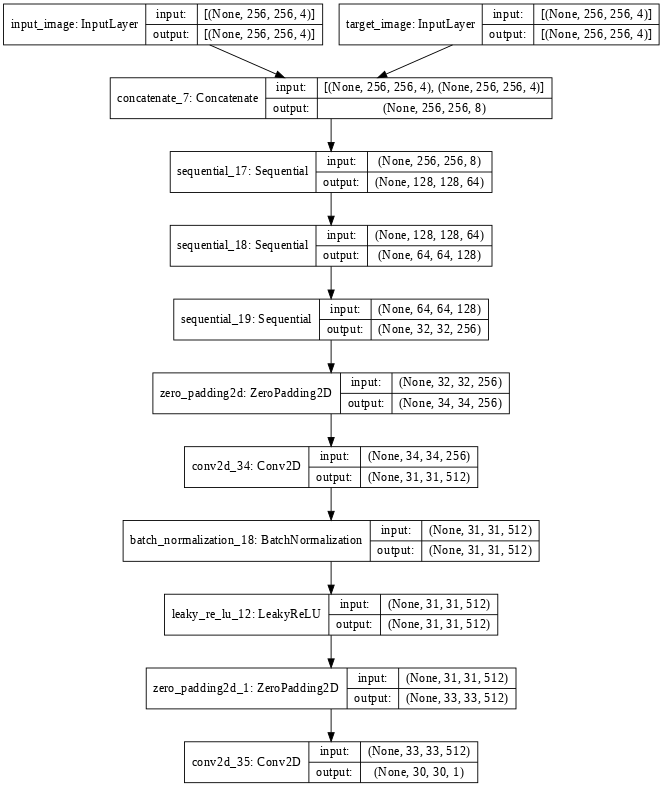

In [24]:
disc = discriminator()
plot_model( disc, show_shapes = True, dpi = 64)

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


In [26]:
generator_optimizer = Adam( learning_rate = 2e-4, beta_1 = 0.5 )
discriminator_optimizer = Adam(learning_rate = 2e-4, beta_1 = 0.5 )

In [27]:
def save_images(model, test_input, target, epoch):
    prediction = model(test_input, training= True)
    plt.figure(figsize = (15,15))


    mask_pred, post_image_pred = tf.experimental.numpy.split(  prediction, [1], axis = -1)

    
    display_list= [ test_input[0] ,target[0], prediction[0], tf.squeeze( mask_pred), post_image_pred[0]]
    
    title = [  "Input Image (Pre-disaster + Post-Mask)", "Ground Truth(Post Disaster + Post-Mask)", 
               "Prediction Image (Post-Disaster + Mask)", "Mask Prediction", "Post Prediction" ]

    plt.figure( figsize= (20,8) )
    for i in range(5):
        if i == 0:
          print( f"test_input shape = {test_input[0].shape}\t\ttarget shape = {target[0].shape}\t\tprediction shape = {prediction[0].shape}" )
        plt.subplot(1, 5, i+1)
        plt.tight_layout()
        plt.title(title[i])
        
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")

    if epoch % 25 == 0:    
      plt.savefig(f"drive/My Drive/Colab Notebooks/modified_data/pre_and_post_joined/output_GAN2/epoch_{epoch}.png")
    
    plt.show()
    plt.close()

In [28]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training = True)
        
        disc_real_output = disc( [input_image, target] , training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
        return gen_total_loss, disc_loss

In [29]:
generator_losses = list()
discriminator_losses = list()
def fit(train_ds, epochs, test_ds):
    
    for epoch in range(0,epochs+1):
        start = time.time()
        test_ds = test_ds.shuffle( 10 )
        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)
        
        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)
        
        
        print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))
        generator_losses.append( gen_loss)
        discriminator_losses.append( disc_loss )

        
        if epoch % 25 == 0:
           gen.save( f"drive/My Drive/Colab Notebooks/modified_data/pre_and_post_joined/saved_modelsC/generator/gen_model_{epoch}.h5" )
           disc.save( f"drive/My Drive/Colab Notebooks/modified_data/pre_and_post_joined/saved_modelsC/discriminator/disc_model_{epoch}.h5" )
      

In [30]:
epochs = 10
fit(train_dataset, epochs, test_dataset)

Output hidden; open in https://colab.research.google.com to view.